# WTTE-pipeline : data-munging template


Simple pipeline. Take by-timestamp records-data, aggregate over larger timeinterval or use it as a continuous measurement. The latter is not yet properly supported.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte

from IPython import display

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Example pipe

FLOW :
1. Munge df ( want id,time to be unique keys)
2. Decide on what happens between observed timesteps
    * Discrete time:
        * Pad between timesteps (use t_elapsed) or not (use t_ix) 
    * Continuous time:
        * Do not pad between timesteps as 'step' is undefined.
3. Embed in fix-format tensor via rightpadding
    
#### Devils in the details: Continuous, discrete and discretized time is different.

t_elapsed = integer or double time 0,1,19,30,...

t_ix  = integer dense rank of t_elapsed 0,1,2,3,...

t = t_elapsed or t_ix depending on context. Good practice to be specific or keep all of them. Premature optimization is the yadayada

### Meta-example: Tensorflow commit data

    #!/bin/bash
    # Go to a git-repository and neatly export the commit log.
    # assumes "_Z_Z_Z_" and "_Y_Y_" "_X_X_" as unused characters 
    # Truncate subject line sanitized (%f) or not (%s) to 79 %<(79,trunc)%f
    echo commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted>../tensorflow_log.csv;
    git log --oneline --pretty="_Z_Z_Z_%h_Y_Y_\"%an\"_Y_Y_%at_Y_Y_\"%<(79,trunc)%f\"_Y_Y__X_X_"  --stat    \
        | grep -v \| \
        | sed -E 's/@//g' \
        | sed -E 's/_Z_Z_Z_/@/g' \
        |  tr "\n" " "   \
        |  tr "@" "\n" |sed -E 's/,//g'  \
        | sed -E 's/_Y_Y_/, /g' \
        | sed -E 's/(changed [0-9].*\+\))/,\1,/'  \
        | sed -E 's/(changed [0-9]* deleti.*-\)) /,,\1/' \
        | sed -E 's/insertion.*\+\)//g' \
        | sed -E 's/deletion.*\-\)//g' \
        | sed -E 's/,changed/,/' \
        | sed -E 's/files? ,/,/g'  \
        | sed -E 's/_X_X_ $/,,/g'  \
        | sed -E 's/_X_X_//g' \
        | sed -E 's/ +,/,/g' \
        | sed -E 's/, +/,/g'>>../tensorflow_log.csv

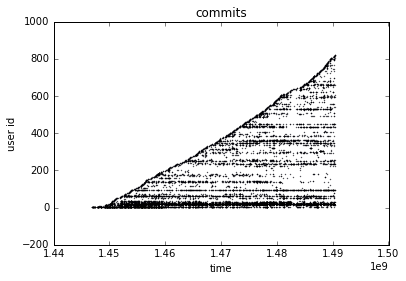

,commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted,id
15718,f41959c,Manjunath Kudlur,1446856078,TensorFlow-Initial-commit-of-TensorFlow-librar...,1900,391534,0,1
15717,cd9e60c,Manjunath Kudlur,1446863831,TensorFlow-Upstream-latest-changes-to-Git ...,72,1289,958,1
15711,71842da,Manjunath Kudlur,1447019816,TensorFlow-Upstream-latest-changes-to-git ...,14,110,110,1
15710,1d3874f,Manjunath Kudlur,1447024477,TensorFlow-Upstream-changes-to-git ...,22,430,405,1
15709,b2dc60e,Manjunath Kudlur,1447033308,TensorFlow-Upstream-changes-to-git ...,34,398,314,1
...,...,...,...,...,...,...,...,...
9,22d50b0,Zhaojun Zhang,1490381393,explicitly-assign-to-dtype-for-tf.Variable-cod...,1,5,5,817
8,f843fb9,Quim Llimona,1490381424,Typo-in-README.md-8699 ...,1,1,1,818
4,241d4ab,Sahit Chintalapudi,1490414217,Update-Tensorboard-readme-with-fixed-links ...,1,2,2,819
3,40d6853,Androbin,1490441778,documentation-formatting-fix ...,1,1,1,820


In [2]:
pd.options.display.max_rows = 10

path = "/path-to-where-you-ran-get_data.sh"
#df = pd.read_csv(path+'/mxnet_log.csv',error_bad_lines=False)
#df = pd.read_csv(path+'/theano_log.csv',error_bad_lines=False)
#df = pd.read_csv(path+'/keras_log.csv',error_bad_lines=False)
#df = pd.read_csv(path+'/h2o_log.csv',error_bad_lines=False) 
df = pd.read_csv(path+'/tensorflow_log.csv',error_bad_lines=False)
df.fillna(0,inplace=True)

# Create a fictitious integer id based on first commit.
# (order has no downstream implications except easy plotting.)
id_col = 'id'
df[id_col] = df.groupby(["author_name"], group_keys=False).\
               apply(lambda g: g.time_sec.min().\
               astype(str)+g.author_name).\
               rank(method='dense').astype(int)

df.plot(kind='scatter', x='time_sec', y='id',s=0.1)
plt.title('commits')
plt.xlabel('time')
plt.ylabel('user id')
plt.show()
    
df.sort_values(['id','time_sec'],inplace=True)

df

In [3]:
# dt = wallclock time, global timestep i.e 2012-01-01,...
abs_time_col='dt'
# t  = elapsed time, local timestep i.e 0,1,2,10,...
t_col = 't_elapsed' 
is_discrete = True
# Does the explicit rows in dataset cover each sequence whole life?
sequences_terminated = False
numeric_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]

if is_discrete:
    # Convert nanosec to date
    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s').dt.date
    # Last timestep may be incomplete/not fully measured so drop it.
    df = df.loc[df[abs_time_col] <= df[abs_time_col].max()]
else:
    # Left as human readable format for readability.
#    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s')
    df[abs_time_col] = df['time_sec']

# here we have the special case that a row indicates an event:
df['n_commits'] = 1

# Aggregate over the new datetime interval to get id,dt = unique key value pair
df = df.groupby([id_col,'author_name',abs_time_col],as_index=False).\
    agg(dict.fromkeys(numeric_cols, "sum"))#.reset_index()

# event = if something special happened i.e commit.
df['event'] =  (df.n_commits>0).astype(int)

if not sequences_terminated:
    # Assuming each sequence has its own start and is not terminated by last event:
    # Add last time that we knew the sequence was 'alive'.
    df = tte.df_join_in_endtime(df,
               per_id_cols=[id_col,'author_name'], 
               abs_time_col=abs_time_col,nanfill_val = 0)
    # Warning: fills unseen timesteps with 0
    
# Add "elapsed time" t_elapsed = 0,3,99,179,.. for each user. 
df[t_col] = df.groupby([id_col], group_keys=False).apply(lambda g: g.dt-g.dt.min())

if is_discrete:
    # Make it a well-behaved integer:
    # infer the discrete stepsize as the first component of the timedelta
    df[t_col] = df[t_col].dt.components.ix[:,0] 
else:
    # Add t_ix = 0,1,2,3,.. and set as primary user-time indicator.
    # if we pass t_elapsed as t_col downstream we'll pad between observed secs
    df['t_ix'] = df.groupby([id_col])[t_col].rank(method='dense').astype(int)-1
    t_col = 't_ix'

df

,id,author_name,dt,files_changed,n_commits,lines_deleted,lines_inserted,event,t_elapsed
821,1,Manjunath Kudlur,2015-11-07,1972,2,958,392823,1,0
822,1,Manjunath Kudlur,2015-11-08,36,2,515,540,1,1
823,1,Manjunath Kudlur,2015-11-09,68,7,1755,1888,1,2
824,1,Manjunath Kudlur,2015-11-20,1271,1,1067,18402,1,13
825,1,Manjunath Kudlur,2015-11-25,322,3,2888,5183,1,18
...,...,...,...,...,...,...,...,...,...
7105,818,Quim Llimona,2017-03-24,1,1,1,1,1,0
817,818,Quim Llimona,2017-03-25,0,0,0,0,0,1
818,819,Sahit Chintalapudi,2017-03-25,1,1,2,2,1,0
819,820,Androbin,2017-03-25,1,1,1,1,1,0


In [4]:
events = tte.df_to_padded(df,['event'],t_col=t_col).squeeze()
if is_discrete:
#    padded_t = np.ones_like(events).cumsum(axis=1)-1
    padded_t = None
else:
    padded_t = tte.df_to_padded(df,['t_elapsed'],t_col=t_col).squeeze()

padded_tte = tte.padded_events_to_tte(events,is_discrete=is_discrete,t_elapsed=padded_t)
padded_u = tte.padded_events_to_not_censored(events,is_discrete)

seq_lengths = (False==np.isnan(events)).sum(1)


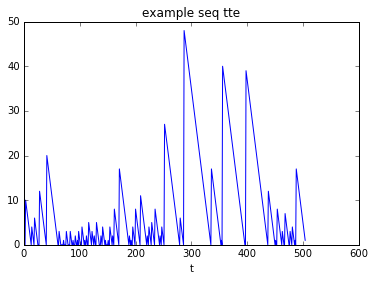

Sequences ordered by length:


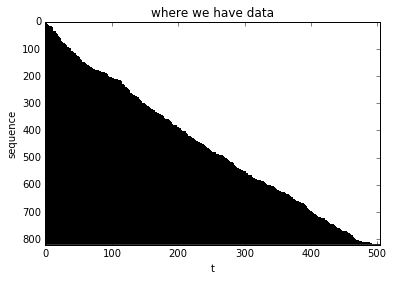

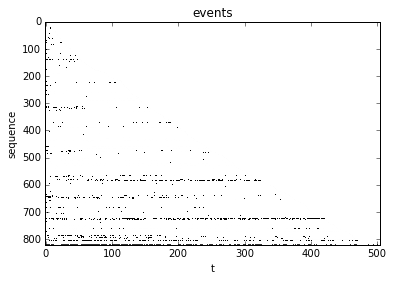

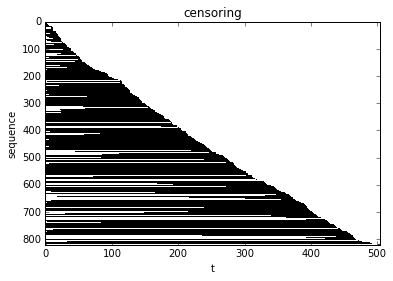

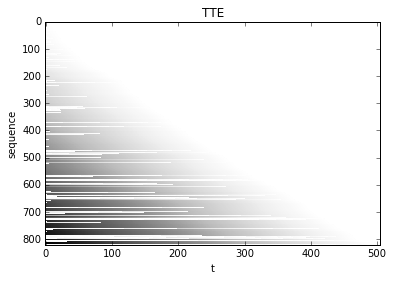

Fixed on a timeline (not necessary but cool):


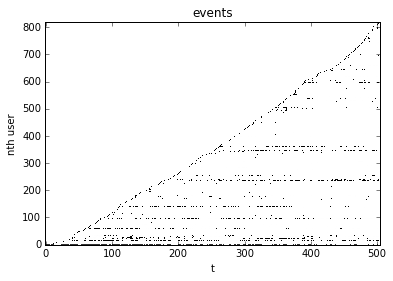

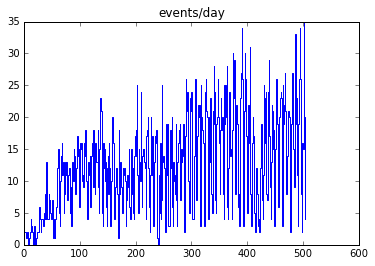

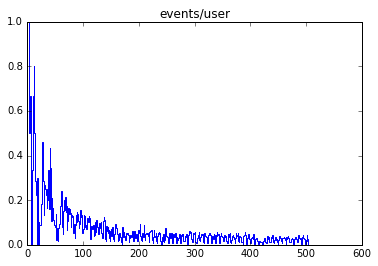

In [5]:
if is_discrete:
    plt.plot(padded_tte[0,:])
else:
    plt.plot(padded_t[0,:],padded_tte[0,:])
plt.title('example seq tte')
plt.xlabel('t')
plt.show()

m = np.argsort(seq_lengths)
print('Sequences ordered by length:')
plt.imshow(1-np.isnan(events)[m,:],interpolation='none', aspect='auto',cmap='Greys')
plt.title('where we have data')
plt.ylabel('sequence');plt.xlabel('t');
plt.show()

plt.imshow(events[m,:],interpolation='none', aspect='auto',cmap='Greys')
plt.title('events')
plt.ylabel('sequence');plt.xlabel('t');
plt.show()

plt.imshow(1-padded_u[:,:][m,:],interpolation='none', aspect='auto',cmap='Greys')
plt.title('censoring')
plt.ylabel('sequence');plt.xlabel('t');
plt.show()

plt.imshow(padded_tte[:,:][m,:],interpolation='none', aspect='auto',cmap='Greys')
plt.title('TTE')
plt.ylabel('sequence');plt.xlabel('t');
plt.show()

print('Fixed on a timeline (not necessary but cool):')
if is_discrete:    
    user_starttimes = df[['id','dt',]].groupby('id').aggregate('min')['dt']

    padded = tte.df_to_padded(df,['event'],t_col = t_col)
    padded = padded[:,:,0]

    padded_timelines,_,_ = tte.padded_to_timelines(padded,user_starttimes)

    fig,ax=tte.plot_timeline(padded_timelines)

    plt.show()
    plt.plot(np.nansum(padded_timelines,0),drawstyle='steps-post')
    plt.title('events/day')
    plt.show()

    plt.plot(np.nanmean(padded_timelines,0),drawstyle='steps-post')
    plt.title('events/user')
    plt.show()
    del padded
else:
    # TODO scale_x_discrete and pixelize events
    df.plot(kind='scatter', x='dt', y='id',s=0.1)
    plt.title('events')
    plt.xlabel('user id')
    plt.show()

# Final fix before training
From a nice docstring:

    """
        Feature cols : data available at timestamp
        Target  cols : not known at timestamp

        discrete case: "event = 1 if event happens today"
         at 2015-12-15 (00:00:00) we know n_commits..
        ..to 2015-12-14 (23.59:59)
        If no event until 
            2015-12-15 (23:59:59) then event = 0
         at 2015-12-15 (23:59:59)

        continuous case: "event =1 if event happens now"
         at 2015-12-15 (00:00:00) we know n_commits..
        ..to 2015-12-15 (00:00:00)
        If no event at
            2015-12-15 (00:00:00) then event = 0
         at 2015-12-15 (00:00:00)

        -> if_discrete we need to roll data intent as features to the right. Consider this:
        As observed after the fact: 
        event   : [0,1,0,0,1]
        feature : [0,1,2,3,4]
        ...features and and target at t generated at [t,t+1)!
        As observed in realtime and what to feed to model:
        event   : [0,1,0,0,1,?]
        feature : [?,0,1,2,3,4] <- last timestep can predict but can't train
        ...features at t generated at [t-1,t), target at t generated at [t,t+1)!
          -> First timestep has no features (don't know what happened day before first day)
                 fix: set it to 0 
          -> last timestep  has no target  (don't know what can happen today)
                 fix: don't use it during training. 
        Unfortunately it usually makes sense to decide on fill-value 
        after feature normalization so do it on padded values
    """


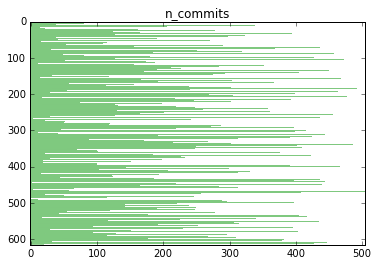

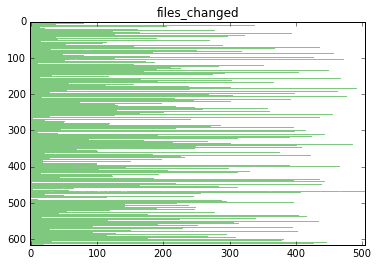

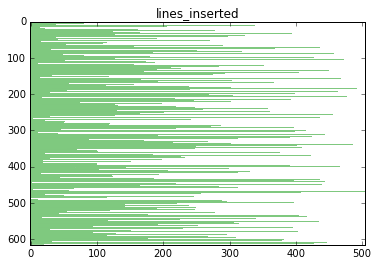

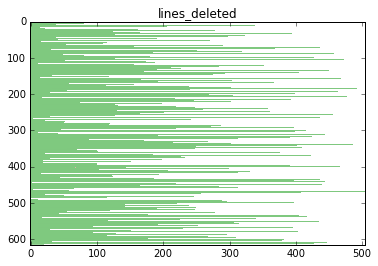

(616, 505, 4) float64
(205, 505, 4) float64
(616, 505, 2) float64
(205, 505, 2) float64


In [6]:
# Hide the truth from the model:
feature_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]
x_ = tte.df_to_padded(df,feature_cols,t_col=t_col)
if is_discrete:
    x_ = tte.shift_discrete_padded_features(x_)

n_timesteps = x_.shape[1]
n_features  = x_.shape[-1]
n_sequences = x_.shape[0]

y_ = np.stack([padded_tte,padded_u],axis=-1)
del padded_tte, padded_u

test_indx = np.floor(y_.shape[0]/4.0).astype(int)
new_ix = np.random.permutation(y_.shape[0]).astype(int)

y_ = y_[new_ix,:,:]
x_ = x_[new_ix,:,:]

# SPLIT

x_train = x_[test_indx:,:,:]
y_train = y_[test_indx:,:,:]
x_test  = x_[:test_indx,:,:]
y_test  = y_[:test_indx,:,:]
train_seq_lengths = (np.isnan(y_train).sum(2) == 0).sum(1).flatten()
test_seq_lengths =  (np.isnan(y_test).sum(2) == 0).sum(1).flatten()
del x_, y_

# NORMALIZE
x_train,means,stds = tte.normalize_padded(x_train)
x_test,_,_         = tte.normalize_padded(x_test,means,stds)

n_test      = x_test.shape[0]
n_train     = x_train.shape[0]
n_features  = x_train.shape[2]
n_timesteps = y_train.shape[1]

for f in xrange(n_features):
    plt.imshow(x_train[:,:,f],aspect='auto',interpolation="none",cmap='Accent')
    plt.title(feature_cols[f])
    plt.show()

# SANITIZE VALUES AND CREATE MASK (weights)
#y_train = np.concatenate([y_train[:,:,:],1.-np.isnan(y_train[:,:,1]).reshape(n_train,n_timesteps,1)],axis=-1)
mask_value = 0 
y_train[np.isnan(y_train)] = mask_value
x_train[np.isnan(x_train)] = mask_value

y_test[np.isnan(y_test)] = mask_value
x_test[np.isnan(x_test)] = mask_value

print x_train.shape,x_train.dtype
print x_test.shape,x_test.dtype
print y_train.shape,y_train.dtype
print y_test.shape,y_test.dtype

# Some thoughts

* Discrete and padding becomes inefficient when we have lots of sequences over long periods with few events. Discretization is lossy.
* Continous makes sense if we have long pauses over long periods but may suddenly need resolution. Problematic with lot's of events and causes expensive imbalance if few users have extreme amounts of events
